In [3]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils 

plt.style.use('ggplot')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nose\config.py:178: DeprecationWarning: invalid escape sequence \.
  """


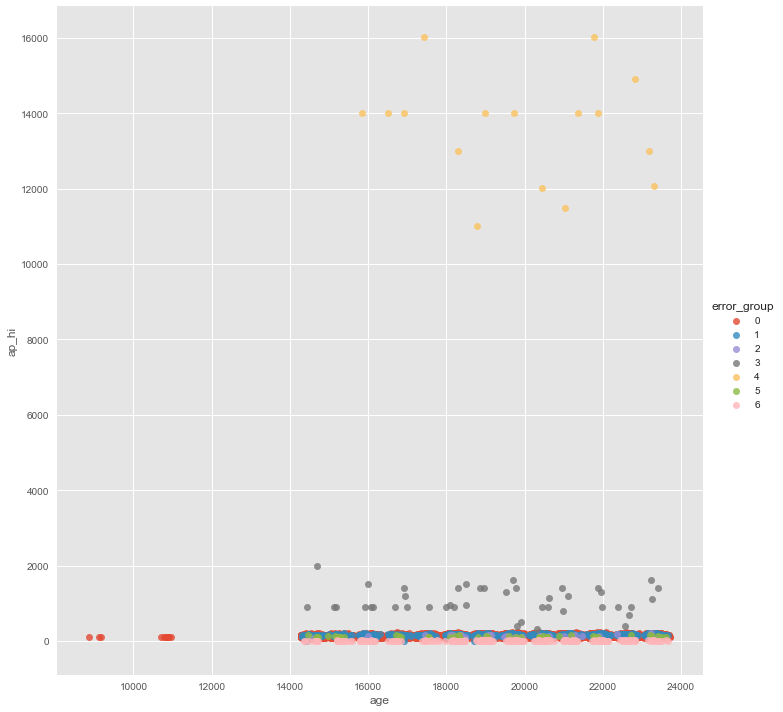

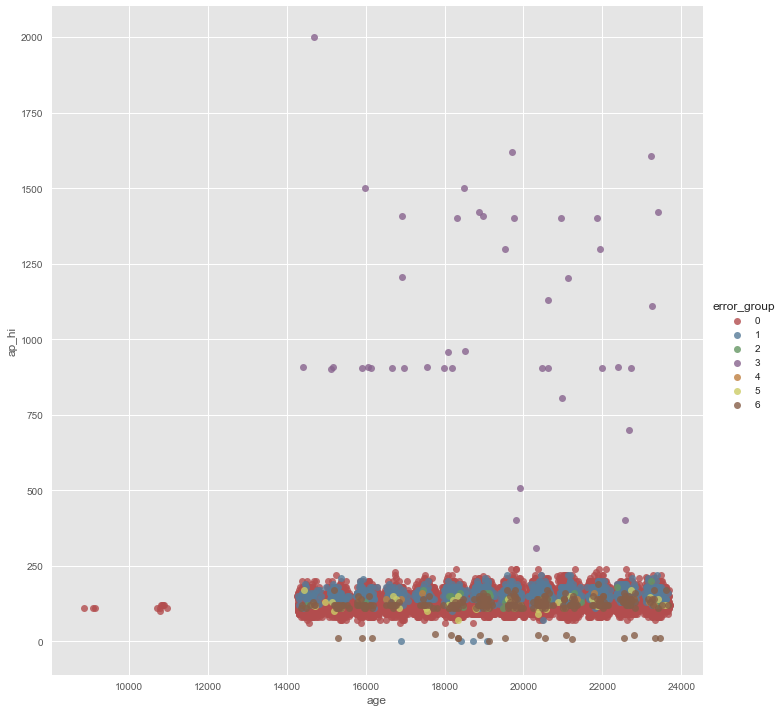

In [130]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')
test['cardio']=-5
data = pd.concat((train,test), axis=0)

data['error_group'] = 0

# weight/height correction
idx = (data['height']<130) & (data['weight']>150)
data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[idx, 'error_group'] = 100-1
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<25, "weight"] += 100

    # preasure correction

data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1

original = data.copy()

data.loc[(data['ap_lo'] < 20), 'error_group'] = 5
data.loc[(data['ap_hi'] < 50), 'error_group'] = 6
data.loc[(data['ap_lo'] > 250), 'error_group'] = 1
data.loc[(data['ap_lo'] > 4000), 'error_group'] = 2
data.loc[(data['ap_hi'] > 250), 'error_group'] = 3
data.loc[(data['ap_hi'] > 10000), 'error_group'] = 4

data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10

idx = data['ap_hi'] > 10000
data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100

data.loc[data['ap_lo'].isin([1000,1200]), 'ap_lo'] /= 10





# manual_update = [
#         (12494, ['ap_hi', 'ap_lo'], [120, 80]),
#         (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
#         (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
#         (51749, ['ap_hi', 'ap_lo'], [120, 80]),
#         (57807, ['ap_hi', 'ap_lo'], [170, 100]),
#         (60477, ['ap_hi', 'ap_lo'], [110, 80]),
#         (91198, ['ap_hi', 'ap_lo'], [100, 90]),
#         (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
#     ]
# for idx, cols, update in manual_update:
#     data.loc[data['id']==idx, cols] = update


original['error_group']=data['error_group']
sns.lmplot(x='age', y='ap_hi', data=original, hue='error_group', fit_reg=False, size=10)
sns.lmplot(x='age', y='ap_hi', data=data.loc[:], hue='error_group', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.5))

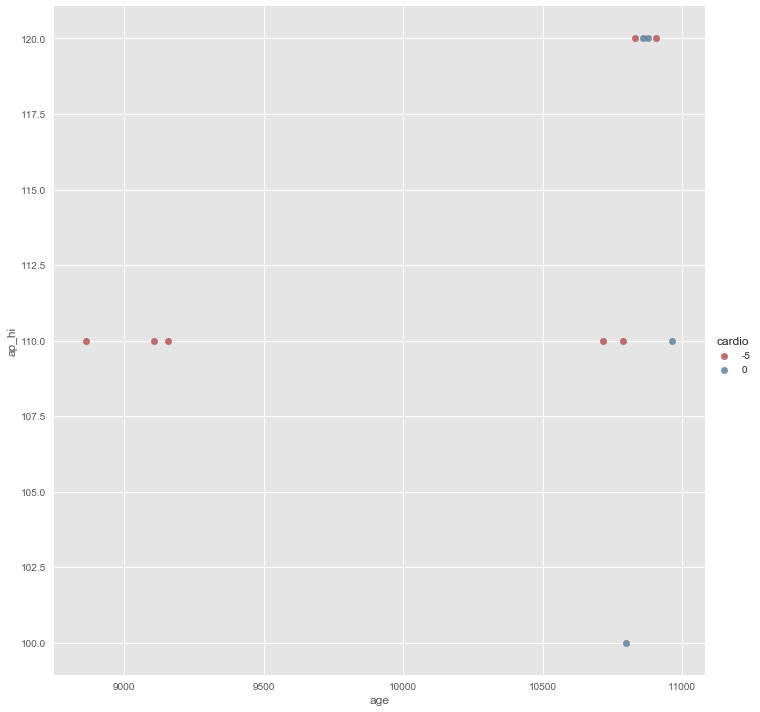

In [137]:
sns.lmplot(x='age', y='ap_hi', data=data.loc[data['age']<12000], hue='cardio', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.5))

In [134]:
data.loc[data['age']<12000]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,error_group
6219,8850,10878,1,175,59.0,120,80.0,1,1,0.0,0.0,1.0,0,0
22343,31922,10798,2,175,92.0,100,60.0,1,1,0.0,0.0,1.0,0,0
30666,43842,10859,1,159,59.0,120,80.0,1,1,0.0,0.0,1.0,0,0
55905,79749,10964,1,160,59.0,110,70.0,1,1,0.0,0.0,1.0,0,0
1414,4831,8865,2,159,67.0,110,80.0,1,1,0.0,0.0,1.0,-5,0
3375,11239,9107,2,164,62.0,110,60.0,1,1,0.0,NaN,0.0,-5,0
6773,22595,10717,2,169,65.0,110,80.0,1,1,0.0,0.0,1.0,-5,0
12201,40593,10786,2,163,52.0,110,80.0,1,1,0.0,0.0,1.0,-5,0
16957,56506,10905,2,173,70.0,120,80.0,1,1,0.0,0.0,1.0,-5,0
18670,62232,10831,1,165,77.0,120,80.0,1,1,0.0,0.0,1.0,-5,0


In [138]:
X_test.index[X_test['age']<12000]

Int64Index([1414, 3375, 6773, 12201, 16957, 18670, 28239], dtype='int64')

In [136]:
X_test.iloc[28239]

id                  94289.000000
age                  9158.000000
gender                  1.000000
height                163.000000
weight                 59.000000
ap_hi                 110.000000
ap_lo                  70.000000
cholesterol             2.000000
gluc                    1.000000
smoke                        NaN
alco                    0.000000
active                  1.000000
error_group             0.000000
BMI                    22.206331
ap_dif                 40.000000
MAP                    83.333333
age_years              25.000000
age_group               0.000000
age_group_gender        0.000000
age_group_MAP           1.000000
gender_MAP            292.000000
Name: 28239, dtype: float64

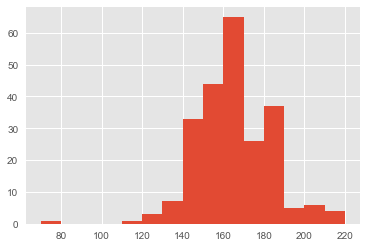

In [157]:
data.loc[(data['ap_lo']>250)&(data['ap_lo']<4000)&(data['ap_lo']%100==0), 'ap_hi'].hist(bins=15)

In [152]:
data.loc[data['ap_lo']==100, 'ap_hi'].mean()

154.2205710955711

In [153]:
data.loc[data['ap_lo']==110, 'ap_hi'].mean()

164.34561403508772

In [57]:
np.sum(data['ap_lo']==103)

10

In [622]:
U = data.loc[data['cardio']>=0]
U.groupby('error_group')['cardio'].mean()

error_group
0     0.494946
1     0.851453
2     0.541667
3     0.580645
4     0.777778
5     0.370370
6     0.497297
96    0.000000
98    0.363636
99    0.666667
Name: cardio, dtype: float64

In [623]:
K = U.groupby('error_group').size()
mean_loc = U.groupby('error_group')["cardio"].mean()
glob_mean = U['cardio'].mean()
alpha=10
values = (mean_loc * K + glob_mean * alpha) / (K + alpha)
values

error_group
0     0.494947
1     0.847707
2     0.529324
3     0.560902
4     0.631421
5     0.405324
6     0.497421
96    0.454273
98    0.406156
99    0.578789
dtype: float64

In [20]:
K

NameError: name 'K' is not defined

In [24]:
data.loc[data['weight']<25]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,error_group
26806,38312,23284,1,157,23.0,110,80.0,1,1,0.0,0.0,1.0,0,98
29488,42156,20408,2,177,22.0,120,80.0,1,1,1.0,1.0,1.0,0,98
33817,48318,21582,2,178,11.0,130,90.0,1,1,0.0,0.0,1.0,1,98
57858,82567,18804,2,165,10.0,180,1100.0,2,2,0.0,0.0,1.0,1,98
60188,85931,21855,1,162,21.0,120,80.0,2,1,0.0,0.0,1.0,1,98
259,854,15187,2,183,13.0,120,80.0,1,1,0.0,1.0,1.0,-5,98
2317,7812,19785,1,157,10.0,120,80.0,1,1,0.0,0.0,1.0,-5,98
16349,54609,16018,1,169,16.3,130,80.0,1,1,0.0,NaN,0.0,-5,98
17418,58027,14848,2,170,20.0,120,80.0,1,1,0.0,0.0,0.0,-5,98
28825,96186,19026,1,169,10.0,120,80.0,1,1,0.0,NaN,1.0,-5,98


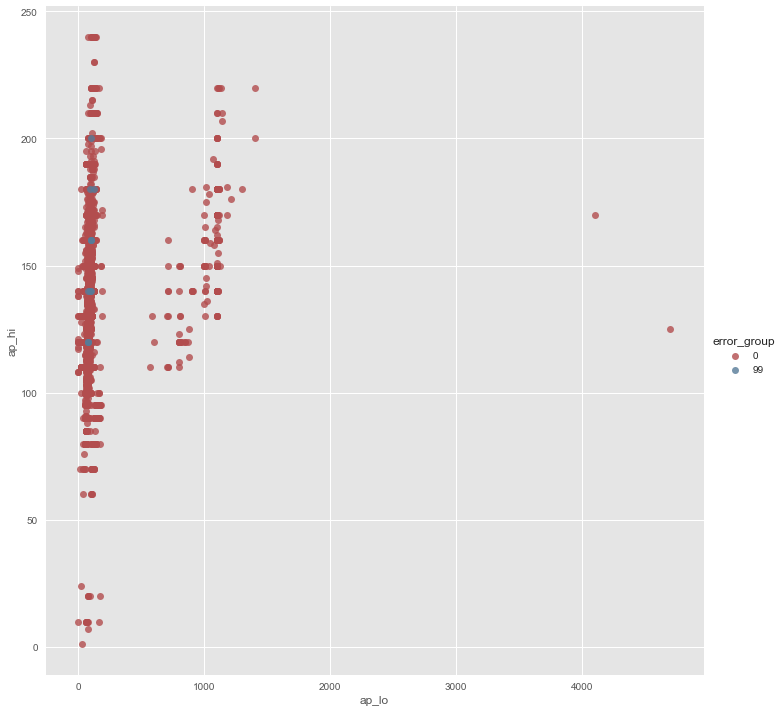

In [633]:
sns.lmplot(x='ap_lo', y='ap_hi', data=data.loc[(data['ap_hi']<250)&(data['ap_lo']<5000)], hue='error_group', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.5))

In [204]:
def clean_data(data):
    data['error_group'] = 0

    # weight/height correction
    idx = (data['height']<130) & (data['weight']>150)
    data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[idx, 'error_group'] = 100-1
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<25, "weight"] += 100

    # preasure correction

    data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
    data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1
    
#     for i in range(10):
#         data[str(i)+'hi'] = data['ap_hi'].apply(lambda x: str(x).count(str(i)))
#         data[str(i)+'lo'] = data['ap_lo'].apply(lambda x: str(x).count(str(i)))
#         data[str(i)+'hilo'] = data[str(i)+'hi']+data[str(i)+'lo']
#         data=data.drop(str(i)+'lo', axis=1)

#     data.loc[(data['ap_lo'] < 20), 'error_group'] = 5
#     data.loc[(data['ap_hi'] < 50), 'error_group'] = 6
    # data.loc[(data['ap_lo'] > 250), 'error_group'] = 1
    # data.loc[(data['ap_lo'] > 4000), 'error_group'] = 2
    # data.loc[(data['ap_hi'] > 250), 'error_group'] = 3
#     data.loc[(data['ap_hi'] > 10000), 'error_group'] = 4

    data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
    data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10

    idx = data['ap_hi'] > 10000
    data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
    data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100

#     data.loc[data['ap_lo'].isin([1100])&(data['ap_hi']>160), 'ap_lo'] = 110
#     data.loc[data['ap_lo'].isin([1100]), 'ap_lo'] = 100
#     data.loc[(data['ap_lo']>250)&(data['ap_lo']<4000)&(data['ap_lo']%100==0), 'ap_lo'] /= 10
    
    manual_update = [
        
# id	age	gender	height	weight	ap_hi	ap_lo	cholesterol	gluc	smoke	alco	active	cardio	BMI
# 12494	16905	2	163	63.0	1	2088	1	1	1.0	0.0	1.0	0	23.711845
# 42591	18191	2	162	63.0	140	1900	1	1	1.0	0.0	1.0	1	24.005487
# 78873	20323	1	168	68.0	130	1900	1	1	0.0	0.0	1.0	0	24.092971
# 51749	18419	1	169	62.0	1	2088	1	1	0.0	0.0	1.0	-5	21.707923
        (12494, ['ap_hi', 'ap_lo'], [120, 80]),
        (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
        (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
        (51749, ['ap_hi', 'ap_lo'], [120, 80]),
        
# 57807	20496	1	164	62.0	70	1100	1	1	0.0	0.0	0.0	0	23.051755
# 60477	18716	1	171	80.0	1	1088	1	1	0.0	0.0	1.0	1	27.358845
# 91198	18182	2	186	95.0	100	901	2	2	0.0	0.0	1.0	0	27.459822
# 6580	19079	1	176	92.0	1	1099	1	1	0.0	NaN	1.0	-5	29.700413
        (57807, ['ap_hi', 'ap_lo'], [170, 100]),
        (60477, ['ap_hi', 'ap_lo'], [110, 80]),
        (91198, ['ap_hi', 'ap_lo'], [100, 90]),
        (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
        
# 44701	22801	1	163	115.0	20	170	1	1	0.0	0.0	1.0	1	43.283526
# 94673	22551	1	169	88.0	10	160	3	3	0.0	0.0	0.0	1	30.811246
        (44701, ['ap_hi', 'ap_lo'], [120, 70]),
        (94673,  ['ap_hi', 'ap_lo'], [110, 60]),
        
    ]
    for idx, cols, update in manual_update:
        data.loc[data['id']==idx, cols] = update
        

    return data

def new_features(data):
    data["BMI"] = 10000 * data["weight"] / (data["height"] * data["height"])
    data["ap_dif"] = data["ap_hi"] - data["ap_lo"]
    data["MAP"] = data["ap_lo"] + data["ap_dif"] / 3.0
    
    data["age_years"] = np.round(data["age"] / 365)
    
    age_bins = [0, 10000, 14000, 14980, 15700, 16420, 17140, 17890, 18625, 19355, 20090, 20820, 21555, 22280, 22990, 24000]
    age_names = [25, 30, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
    data["age_group"] = pd.cut(data['age'], age_bins, labels=age_names)

    return data

In [205]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = clean_data(train)
test = clean_data(test)

train = new_features(train)
test = new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

columns_to_interact = ['age_group', 'gender', 'MAP']
temp = utils.generate_interactions(X_train, columns_to_interact, 2)
X_train = pd.concat((X_train, temp), axis=1)
X_test = pd.concat((X_test, utils.generate_interactions(X_test, columns_to_interact, 2)), axis=1)
print(temp.columns)

X = pd.concat((X_train, X_test), axis=0)

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
label_encoder_dict = defaultdict(LabelEncoder)
columns_to_encode = ['age_group'] + list(temp.columns)


X[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].fit(x))
X_train[columns_to_encode] = X_train[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))
X_test[columns_to_encode] = X_test[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))

Index(['age_group_gender', 'age_group_MAP', 'gender_MAP'], dtype='object')


In [206]:
bins = [0, 100,120,140,160,180,20000]
names = list(range(len(bins)-1))
a = pd.cut(X_train['ap_hi'], bins, labels=names)

# bins = [0,39, 49, 54, 59, 65]
# names = list(range(len(bins)-1))
# e = pd.cut(X_train['age_years'], bins, labels=names)

rew = (X_train['age_group'].astype('str')
    + X_train['gender'].apply(str)
    + X_train['smoke'].apply(str)
    + X_train['cholesterol'].apply(str)
#     + X_train['error_group'].apply(str)
#        + a.astype('str')
    )
rew.loc[X_train['error_group']!=0]='error' + X_train.loc[X_train['error_group']!=0, 'error_group'].astype('str')
rew.loc[X_train['age_years']<39] = 'young'

rew.loc[rew.isin((rew).value_counts()[(rew).value_counts()<10].index)] = "hacky"
# rew.value_counts()

In [185]:
# gg=X_train.copy()
# gg['cardio']=y_train
# gg.groupby('age_years')['cardio'].mean()

In [207]:
import utils
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model1",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
              stratification_groups=rew,
              alpha=10,
#               seed=150
             )

# 10 folds logloss:
# [0.53337375608164872, 0.54383512573702564, 0.54933568721313042, 0.53636374759398142, 0.53691646032597429, 0.52464769829645996, 0.54204243966263932, 0.54485908761113078, 0.53615270238281587, 0.53607948700518659]
# mean: 0.538360619191
# std: 0.00659752066022
# model1 results saved!


10 folds logloss:
[0.54634742471110076, 0.54040708924622538, 0.53302091852367506, 0.54136571062104777, 0.53420203621969187, 0.54073916724587501, 0.53175325886950153, 0.53402971717200143, 0.54269209616839531, 0.5413113605080544]
mean: 0.538586877929
std: 0.00466735409713
15 Splits logloss:
[0.5386757151678816, 0.53655804763427173, 0.53356596243646293, 0.53788244409646335, 0.53977552584728861, 0.53198303188125995, 0.53257031395485765, 0.53922522089348135, 0.53925919275319201, 0.5374306553664816, 0.53909599638920169, 0.53989681459822503, 0.53941367570878074, 0.54471169824173371, 0.53570348936809531]
mean: 0.537716518956
std: 0.00316619776738
model1 results saved!


(0.53858687792855697, 0.53771651895584516)

In [447]:
# ids = X_train['id'].isin([12494,42591,78873,51749,57807,60477,91198,6580,])
# ids = X_train['id'].isin([2845,34120,60565,60948,92655,98095,24871,30877,88161,99929,])
ids = X_train['id'].isin([44701, 94673])

predict, _, _, _, = utils.load_model('model1')

from sklearn.metrics import log_loss
log_loss(y_train[ids], predict[ids])
# 0.92
# 0.69817735007823967

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [ ]:
10 folds logloss:
[0.53316211343285513, 0.5435962031879279, 0.54867728201528698, 0.53651873490238378, 0.53727909470172197, 0.52475207112291411, 0.54273463114564169, 0.54496225122940489, 0.53624431557193275, 0.53549874592974667]
mean: 0.538342544324
std: 0.00652689409999
15 Splits logloss:
[0.53888477666993306, 0.54218950152605772, 0.5392684533560792, 0.53284370407408765, 0.54322835531445401, 0.53276219115927792, 0.53799097376426674, 0.53380737949959212, 0.53834701399032414, 0.53868100204313374, 0.53622424516843592, 0.54254933874263722, 0.5373211861088083, 0.53968248019803311, 0.53515638711298441]
mean: 0.537929132582
std: 0.00321056488567


10 folds logloss:
[0.53340139800318942, 0.54402493769300042, 0.54889854919817616, 0.53657680791536166, 0.5376343916425822, 0.52487328929334087, 0.54225123099876382, 0.54505014110314798, 0.53629562514911466, 0.53622634612240239]
mean: 0.538523271712
std: 0.00649449868547
15 Splits logloss:
[0.53917368484789485, 0.54243159511267092, 0.53919880670322651, 0.53312569179410219, 0.54332352251426552, 0.53300622107990214, 0.53834041199188365, 0.53374835987972291, 0.53846484410674456, 0.53862878334299402, 0.53628739092451549, 0.54303022176322135, 0.53753077044533903, 0.53993105139769959, 0.5350797644216887]
mean: 0.538086741355
std: 0.00325468168847
model1 results saved!

In [245]:
pd.set_option('display.height', 1500)
pd.set_option('display.max_rows', 1500)

height has been deprecated.



In [8]:
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model2",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53309790708708416, 0.54359243857297601, 0.54890140052556891, 0.53642556434372846, 0.53749371005064162, 0.52468880555427133, 0.54246732961030175, 0.54436845314766624, 0.53582375120982972, 0.53559055680787115]
mean: 0.538244991691
std: 0.00651555820791
15 Splits logloss:
[0.53857612030253121, 0.54195015569736871, 0.53886708747016854, 0.53258749437021613, 0.54311395840880761, 0.53260968033189415, 0.53785477926388647, 0.53366843150442345, 0.53826849770720664, 0.53858157204729817, 0.53568596995220708, 0.54229568004356754, 0.53723669891985093, 0.5395083833795834, 0.53503186514089707]
mean: 0.537722424969
std: 0.00321148219295
model2 results saved!


(0.53824499169099393, 0.53772242496932721)

In [9]:
import lightgbm as lgb
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
#     'num_leaves': 2**3,
#     'min_child_weight': 1,
    'n_estimators': 50,
    'subsample': 0.8,
#     'reg_alpha': 1.2,
#     'reg_lambda': 0.0,
       
    'nthread': 1,
    'seed': 2707,
    'silent': True,
}

utils.execute_model(lgb.LGBMClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model3",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53326273124104817, 0.54366081574609171, 0.54982847792852396, 0.53617047349716185, 0.53779268210818632, 0.52543117014302609, 0.54211964293601367, 0.5449963624252967, 0.534691710276605, 0.53491188862302863]
mean: 0.538286595492
std: 0.00664338362833
15 Splits logloss:
[0.53818269258859552, 0.54204703238726515, 0.53895395104590471, 0.53289186431020774, 0.54342886476537533, 0.53290211528765308, 0.53751016416283404, 0.53419090612734599, 0.5386278923200426, 0.53852507074906286, 0.53631173726994319, 0.54238360606465252, 0.53735110048807078, 0.53962054000678272, 0.53473820734934885]
mean: 0.537844382995
std: 0.00315895025014
model3 results saved!


(0.53828659549249824, 0.53784438299487236)

In [11]:
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    'tree_method': 'hist',
    'grow_policy': 'depthwise',
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model4",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53309790708708416, 0.54359243857297601, 0.54890140052556891, 0.53642556434372846, 0.53749371005064162, 0.52468880555427133, 0.54246732961030175, 0.54436845314766624, 0.53582375120982972, 0.53559055680787115]
mean: 0.538244991691
std: 0.00651555820791
15 Splits logloss:
[0.53857612030253121, 0.54195015569736871, 0.53886708747016854, 0.53258749437021613, 0.54311395840880761, 0.53260968033189415, 0.53785477926388647, 0.53366843150442345, 0.53826849770720664, 0.53858157204729817, 0.53568596995220708, 0.54229568004356754, 0.53723669891985093, 0.5395083833795834, 0.53503186514089707]
mean: 0.537722424969
std: 0.00321148219295
model4 results saved!


(0.53824499169099393, 0.53772242496932721)

In [ ]:
XP = X_train.copy()
XP['TARGET'] = y_train
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<300)&(XP['ap_lo']<4000)]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
# XP=XP.loc[(XP['TARGET']==0)]
# sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<=XP['ap_lo'])]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)